# Building Words Model
## 1 - Data Preprocessing

In [3]:
from collections import Counter, defaultdict
import csv, json
import random
from time import time

In [95]:
print "[Start Data Preprocessing] ... ..."; t1 = time()

# Reading Training Data
GEO = 0
APP = 1

TOPIC = GEO

content = []
with open('./dataset.txt', 'r') as f:
    reader = csv.reader(f)
    for row in reader:
        content.append(row)

with open('./entities_set.json', "r") as f_j:
    ent_with_info = json.load(f_j)
    
with open('./ent_geojson_3377.json', "r") as f_geo:
    ent_geojson = json.load(f_geo)
    
# Input Entity name to locate the entity section in the whole dataset: Entity Name --> Entity ID
name_to_node = defaultdict()
for key in ent_with_info:
    try:
        name_to_node[ent_with_info[key]['tag']['name']] = key
    except:
        continue

##########  
# Labels #
##########

# Acquire the list of labels
labels = []
for item in content:
    labels.append(item[TOPIC])

# Acquire a set of indexes of Positibe and Negative labelled 'docs'
indexes_of_true = [n for n,l in enumerate(labels) if l == 't']
indexes_of_false = [n for n,l in enumerate(labels) if l == 'f']

#############  
# Sentences #
#############

# Acquire raw sentences
sents = []
for item in content:
    sents.append(item[2])
    
# Reading Cleaned Sentences
cleaned_sents = []
with open('./cleaned_sents.csv', 'rb') as f:
    reader = csv.reader(f)
    for row in reader:
        cleaned_sents.append(row)

# Acquire ent for each sentences
ent_sents = []
type_sents = []
for item in content:
    ent_sents.append(item[3])
    try:
        type_sents.append(ent_with_info[item[3]]['ent_type'])
    except:
        type_sents.append([])

############
# POS tags #
############

# Acquire POS tags
pos_sents = []
with open('./training_pos_tag.csv', 'rb') as csvfile:
    spamreader = csv.reader(csvfile)
    for row in spamreader:
        pos_sents.append(row)
        
print '[Finished] --', round((time() - t1), 3), "s"

[Start Data Preprocessing] ... ...
[Finished] -- 3.22 s


## 2 - Loading and Building Word Models

In [5]:
import gensim, logging, os
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)
corpus = cleaned_sents[:]
# Reading Word2Vec Model
fname = 'wiki_corpus_300.model'
is_overwrite = 0
if os.path.exists(fname) and is_overwrite == 0:
    # load the file if it has already been trained, to save repeating the slow training step below
    model = gensim.models.Word2Vec.load(fname)
else:
    # can take a few minutes, grab a cuppa
    model = gensim.models.Word2Vec(corpus, size=300, min_count=1, workers=4, iter=50) 
    model.save(fname)

2017-05-21 14:04:18,226 : INFO : loading Word2Vec object from wiki_corpus_300.model
2017-05-21 14:04:18,444 : INFO : loading wv recursively from wiki_corpus_300.model.wv.* with mmap=None
2017-05-21 14:04:18,445 : INFO : loading syn0 from wiki_corpus_300.model.wv.syn0.npy with mmap=None
2017-05-21 14:04:18,594 : INFO : setting ignored attribute syn0norm to None
2017-05-21 14:04:18,601 : INFO : loading syn1neg from wiki_corpus_300.model.syn1neg.npy with mmap=None
2017-05-21 14:04:18,752 : INFO : setting ignored attribute cum_table to None
2017-05-21 14:04:18,753 : INFO : loaded wiki_corpus_300.model


In [40]:
# Loading Pre-built Model
from gensim.models.keyedvectors import KeyedVectors

t1=time()
print "[Loading Model] ... ..."

model_ext_200 = KeyedVectors.load_word2vec_format("/Users/boyachen/Downloads/glove.6B/genism.wikivec_200d", binary= False)
model_ext_300 = KeyedVectors.load_word2vec_format("/Users/boyachen/Downloads/glove.6B/genism.wikivec_300d", binary= False)

print "[Finished!]:", time()-t1, "s"

2017-05-19 16:37:12,621 : INFO : loading projection weights from /Users/boyachen/Downloads/glove.6B/genism.wikivec_200d


[Loading Model] ... ...


2017-05-19 16:38:42,362 : INFO : loaded (400000, 200) matrix from /Users/boyachen/Downloads/glove.6B/genism.wikivec_200d
2017-05-19 16:38:42,363 : INFO : loading projection weights from /Users/boyachen/Downloads/glove.6B/genism.wikivec_300d
2017-05-19 16:40:52,611 : INFO : loaded (400000, 300) matrix from /Users/boyachen/Downloads/glove.6B/genism.wikivec_300d


[Finished!]: 219.991565943 s


In [126]:
cut_num = 17000 # Number of Labelled Docs

words_with_t = []
for i, sent in enumerate(corpus): 
    if labels[i] == 't':
        words_with_t.extend(sent)
words_with_t = list(set(words_with_t))

import numpy as np
from time import time

# sent_matrix = np.array([model[word] for word in cleaned_sents[0] if word in model])
# length = sent_matrix.shape[0]
# dimen = sent_matrix.shape[1]
# center = np.array([sum(sent_matrix[:,i])/(np.var(np.array(sent_matrix[:,i]))) for i in range(dimen)])

vector_model = model
dimen = 300

corpus_matrix = []
t1=time()
for i, sent in enumerate(cleaned_sents[:]):
    try:
        if i % 5000 == 0:
            print i, 'done.'
        if sent == []:
            corpus_matrix.append(np.zeros((1,dimen))[0])
            continue
        sent_matrix = np.array([vector_model[word] for word in sent if word in model])
        length = sent_matrix.shape[0]
        center = [sum(sent_matrix[:,i]) / length for i in range(dimen)]
#         # Lower Dimension
#         if len(center) != 2:
#             center = [max(center), min(center)]
        corpus_matrix.append(center)
    except:
        corpus_matrix.append(np.zeros((1,dimen))[0])

print 'time:', time()-t1

t_dataset = np.array(corpus_matrix[:17000])
t_labels = labels[:17000]

p_dataset = np.array(corpus_matrix[17000:])
# p_labels = labels[17000:]

## ! ---------- Imbalance Handling ---------- !

In [123]:
indexes_of_true_r = indexes_of_true[:]
indexes_of_false_r = indexes_of_false[:]
random.shuffle(indexes_of_false_r)
indexes_of_false_r = indexes_of_false_r[:len(indexes_of_true_r) * 3]

indexes_of_r = list(sorted(indexes_of_true_r + indexes_of_false_r))
np.random.shuffle(indexes_of_r) # randomly shuffle the order

t_dataset_r = np.array([t_dataset[i] for i in range(len(t_labels)) if i in indexes_of_r])
t_labels_r = [t_labels[i] for i in range(len(t_labels)) if i in indexes_of_r]

print "size of positive training dataset:", len(indexes_of_true_r)
print "size of negative training dataset:", len(indexes_of_false_r)

size of positive training dataset: 1016
size of negative training dataset: 3048


## 2-d Virsualisation

/Library/Python/2.7/site-packages/matplotlib/figure.py:1742: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


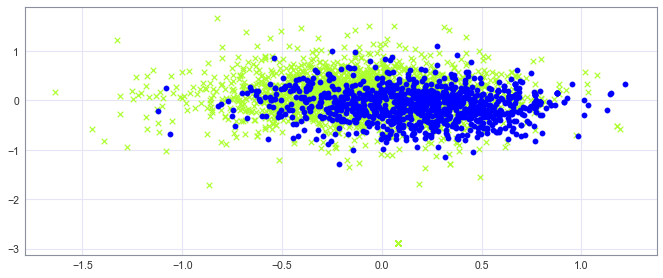

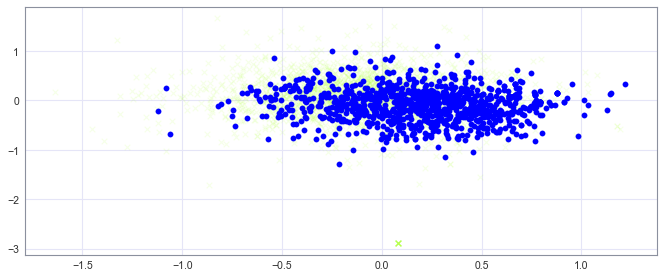

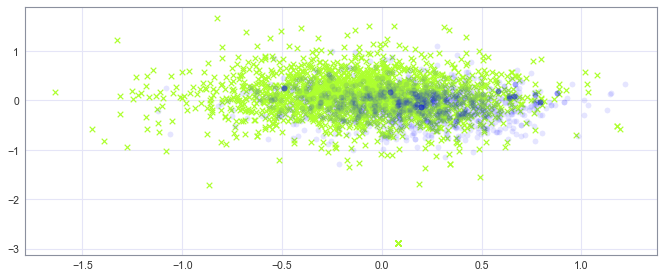

In [53]:
import numpy as np
import matplotlib.pyplot as plt

###########################################################
# True and False
###########################################################

t_database_with_true = []
t_database_with_false = []

for i, item in enumerate(t_dataset_r):
    if t_labels_r[i] == "t":
        t_database_with_true.append(list(item))
    else:
        t_database_with_false.append(list(item))
        
t_database_with_true = np.array(t_database_with_true)
t_database_with_false = np.array(t_database_with_false)

color1 = "greenyellow"
color2 = "blue"

plt.scatter(t_database_with_false[:,0], t_database_with_false[:,1], c=color1, marker='x')
plt.scatter(t_database_with_true[:,0],  t_database_with_true[:,1],  c=color2, marker='o')
plt.show()

# Highlit Different Classes
plt.scatter(t_database_with_false[:,0], t_database_with_false[:,1], c=color1, marker='x', alpha=0.1)
plt.scatter(t_database_with_true[:,0],  t_database_with_true[:,1],  c=color2, marker='o')
plt.show()

plt.scatter(t_database_with_false[:,0], t_database_with_false[:,1], c=color1, marker='x' )
plt.scatter(t_database_with_true[:,0],  t_database_with_true[:,1],  c=color2, marker='o', alpha=0.1)
plt.show()

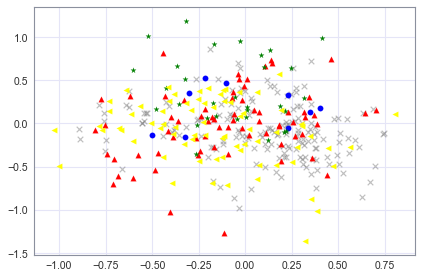

In [92]:
###########################################################
# Classied as in terms of types (2D only)
###########################################################

t_database_type_tourism = []
t_database_type_pub_trapt = []
t_database_type_ament = []
t_database_type_natrual = []
t_database_type_other = []
for i, item in enumerate(t_dataset):
    if type_sents[i] == ['tourism'] and labels[i] == 't':
        t_database_type_tourism.append(list(item))
    elif type_sents[i] == ['public_transport'] and labels[i] == 't':
        t_database_type_pub_trapt.append(list(item))
    elif type_sents[i] == ['amenity'] and labels[i] == 't':
        t_database_type_ament.append(list(item))
    elif type_sents[i] == ['natural'] and labels[i] == 't':
        t_database_type_natrual.append(list(item))
    elif labels[i] == "t":
        t_database_type_other.append(list(item))
t_database_type_tourism = np.array(t_database_type_tourism)
t_database_type_pub_trapt = np.array(t_database_type_pub_trapt)
t_database_type_other = np.array(t_database_type_other)
t_database_type_ament = np.array(t_database_type_ament)
t_database_type_natrual = np.array(t_database_type_natrual)

plt.scatter(t_database_type_other[:,0], t_database_type_other[:,1], c='grey', marker='x', alpha=0.5)
plt.scatter(t_database_type_tourism[:,0], t_database_type_tourism[:,1], c='red', marker='^')
plt.scatter(t_database_type_pub_trapt[:,0], t_database_type_pub_trapt[:,1], c='blue', marker='o')
plt.scatter(t_database_type_ament[:,0], t_database_type_ament[:,1], c='green', marker='*')
plt.scatter(t_database_type_natrual[:,0], t_database_type_natrual[:,1], c='yellow', marker='<')

plt.show()

## Visualizing Multidimensional Data in Python
- Method 1: Two-dimensional slices
- Method 2: PCA Plotting
- Method 3: Linear Discriminant Analysis
- Method 4: Parallel Coordinates

In [8]:
import matplotlib.pyplot as plt
import pandas as pd

from sklearn.decomposition import PCA as sklearnPCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.datasets.samples_generator import make_blobs

from pandas.tools.plotting import parallel_coordinates, andrews_curves

# Multi-dimension vector normalisation
def x_norm(array):
    return (array - min(array)) / (max(array) - min(array)) if (max(array) - min(array)) !=0 else array

### Method 2: PCA Plotting

Principle Component Analysis (PCA) is a method of dimensionality reduction. It has applications far beyond visualization, but it can also be applied here. It uses eigenvalues and eigenvectors to find new axes on which the data is most spread out. From these new axes, we can choose those with the most extreme spreading and project onto this plane. (This is an extremely hand-wavy explanation; I recommend reading more formal explanations of this.)

In Python, we can use PCA by first fitting an sklearn PCA object to the normalized dataset, then looking at the transformed matrix.

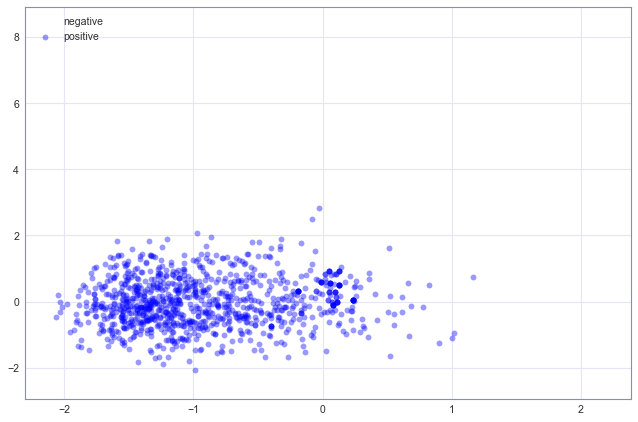

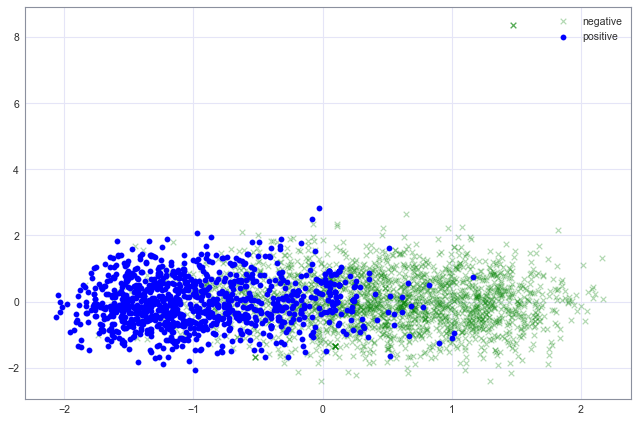

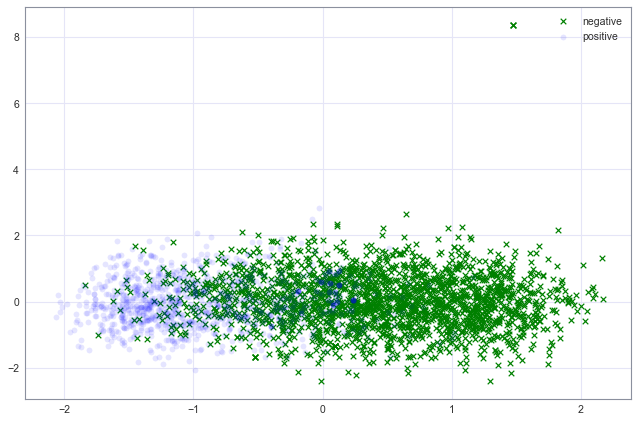

In [120]:
jtplot.figsize(9,6)

t_dataset_norm = np.array([x_norm(r) for r in t_dataset_r])

pca = sklearnPCA(n_components=2)
transformed = pca.fit_transform(t_dataset_norm)

transformed_true = []
transformed_false = []
for i in range(len(transformed)):
    if t_labels_r[i] == "t":
        transformed_true.append(list(transformed[i]))
    else:
        transformed_false.append(list(transformed[i]))
transformed_true = np.array(transformed_true)
transformed_false = np.array(transformed_false)

color1, marker1 = "green", 'x'
color2, marker2 = "blue", 'o'

plt.scatter(transformed_false[:,0], transformed_false[:,1], label = "negative", c=color1, marker=marker1, alpha=0)
plt.scatter(transformed_true[:,0], transformed_true[:,1], label = "positive", c=color2, marker=marker2, alpha = 0.4)

plt.legend(loc=2)
plt.show()

plt.scatter(transformed_false[:,0], transformed_false[:,1], label = "negative", c=color1, marker=marker1, alpha = 0.3)
plt.scatter(transformed_true[:,0], transformed_true[:,1], label = "positive", c=color2, marker=marker2)

plt.legend()
plt.show()

plt.scatter(transformed_false[:,0], transformed_false[:,1], label = "negative", c=color1, marker=marker1)
plt.scatter(transformed_true[:,0], transformed_true[:,1], label = "positive", c=color2, marker=marker2, alpha = 0.1)

plt.legend()
plt.show()

In [105]:
jtplot.figsize(6,4)

color2 = "blue"

for ran in range(10):
    plt.scatter(transformed_true[:(ran+1)*100,0], transformed_true[:(ran+1)*100,1], label = "positive", c=color2, marker=marker2, alpha = 0.3)
    plt.legend(loc=2)
    plt.show()

In [116]:
# for i, arr in enumerate(transformed):
#     if -5 < arr[0] < -3 and -0.25 < arr[1] < 0.25 and labels[indexes_of_r[i]] == 'f':
#         print indexes_of_r[i], "|", labels[indexes_of_r[i]], "|",  sents[indexes_of_r[i]]

### Method 3: Linear Discriminant Analysis

A similar approach to projecting to lower dimensions is Linear Discriminant Analysis (LDA). This is similar to PCA, but (at an intuitive level) attempts to separate the classes rather than just spread the entire dataset.

The code for this is similar to that for PCA:

### Method 4: Parallel Coordinates

The final visualization technique I’m going to discuss is quite different than the others. Instead of projecting the data into a two-dimensional plane and plotting the projections, the Parallel Coordinates plot (imported from pandas instead of only matplotlib) displays a vertical axis for each feature you wish to plot. Each sample is then plotted as a color-coded line passing through the appropriate coordinate on each feature. While this doesn’t always show how the data can be separated into classes, it does reveal trends within a particular class. (For instance, in this example, we can see that Class 3 tends to have a very low OD280/OD315.)

In [104]:
# || Method 4 ||: Parallel Coordinates
# df = pd.concat([pd.DataFrame(t_dataset_r[:,:30]), pd.DataFrame(t_labels_r, columns=["label"])], axis=1)
# parallel_coordinates(df, "label", colormap="summer")
# plt.show()

# Validation

In [125]:
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import accuracy_score, classification_report

def check_results(predictions, classifications):
    lab = ['t', 'f']
#     print "accuracy"
#     print accuracy_score(classifications, predictions)
    print classification_report(classifications, predictions, labels=lab)

############################
# Classifiers from Sklearn #
############################
# # Naive Bayes
from sklearn.naive_bayes import MultinomialNB
clf_nb = MultinomialNB()

# # Support Vector Machine
from sklearn import svm
clf_svm = svm.LinearSVC(C=0.1)

# # Decision Tree
from sklearn.tree import DecisionTreeClassifier
clf_dt = DecisionTreeClassifier()
# # Random Foreset Classifier
from sklearn.ensemble import RandomForestClassifier
clf_rfc = RandomForestClassifier()
# # Bagging Classifier
from sklearn.ensemble import BaggingClassifier
clf_bag = BaggingClassifier()

# # K Neighbors Classifier
from sklearn.neighbors import KNeighborsClassifier
clf_knc = KNeighborsClassifier(n_neighbors=3)

test_clf = [clf_svm, clf_rfc, clf_knc]

t1 = time()
print "[Job Start]"
for clf in test_clf:
#     print 'CLASSIFIER -->', str(clf)
#     print '------- CROSS VALIDATION --------'
    crossval_predicted = cross_val_predict(clf, t_dataset_r, t_labels_r, cv=20)
    check_results(crossval_predicted, t_labels_r)
    print '----------------------------------------------------'
    print '\n'
    
print "[Job Done]:", time()-t1, "s"

[Job Start]
             precision    recall  f1-score   support

          t       0.82      0.84      0.83      1016
          f       0.95      0.94      0.94      3048

avg / total       0.91      0.91      0.91      4064

----------------------------------------------------


             precision    recall  f1-score   support

          t       0.88      0.71      0.79      1016
          f       0.91      0.97      0.94      3048

avg / total       0.90      0.90      0.90      4064

----------------------------------------------------


             precision    recall  f1-score   support

          t       0.82      0.86      0.84      1016
          f       0.95      0.94      0.94      3048

avg / total       0.92      0.92      0.92      4064

----------------------------------------------------


[Job Done]: 32.9004089832 s


In [26]:
def error_checking(real_predictions, labels, verbose):
    t_t = len([i for i in range(len(real_predictions)) if real_predictions[i] == 't' and labels[i] == 't'])
    f_f = len([i for i in range(len(real_predictions)) if real_predictions[i] == 'f' and labels[i] == 'f'])
    t_f = len([i for i in range(len(real_predictions)) if real_predictions[i] == 'f' and labels[i] == 't'])
    f_t = len([i for i in range(len(real_predictions)) if real_predictions[i] == 't' and labels[i] == 'f'])

    print '--Correct--'
    print 'True --> True:', t_t 
    print 'False --> False:', f_f
    print ''
    print '--Incorrect--'
    print 'True --> False:', t_f
    print 'False --> True:', f_t
    print ''
    print '--> Accuracy:', round((t_t+f_f) / float(t_t+t_f+f_t+f_f) , 2)
    print '--> Precision:', round(t_t / float(t_t+f_t) , 2 )
    print '--> Recall:', round(t_t / float(t_t+t_f), 2 )
    print ''
    
    test_case = [l for l in verbose]
    print "Sentence: ",test_case[0],"-->",test_case[1]
    print "-" * 80
    for i, sent in enumerate(sents[:len(real_predictions)]):
        if real_predictions[i] == test_case[1] and labels[i] == test_case[0]:
            print '>', i, '\t|  ', sent

if_train_clf = 1
if if_train_clf == 1:
    real_predictions = clf_rfc.fit(t_dataset_r, t_labels_r).predict(p_dataset)

## Real World - Prediction

In [85]:
import json
import math
import nltk
import wikipedia as wk
lemmatizer = nltk.stem.wordnet.WordNetLemmatizer()
from nltk.corpus import stopwords
stpwords = stopwords.words()

def lemmatize(word):
    lemma = lemmatizer.lemmatize(word,'v')
    if lemma == word:
        lemma = lemmatizer.lemmatize(word,'n')
    return lemma

In [103]:
# # 1 | Read Article (using wikipedia-python API)

# # res = wk.page("melbourne university")
# article = res.content.split("\n")
# # text-preprocessing
# article = [nltk.word_tokenize(line) for line in article if line != ""]



# article = [nltk.word_tokenize(line) for line in article if line != ""]
# article



In [39]:
# ent_with_sents = defaultdict();
# for r, l in enumerate(t_labels):
#     if l == "t":
#         ent_id = ent_sents[r]
#         if ent_id in ent_with_sents:
#             ent_with_sents[ent_id].append(sents[r])
#         else:
#             ent_with_sents[ent_id] = []
#             ent_with_sents[ent_id].append(sents[r])
    
# for r, p in enumerate(real_predictions):
#     if p == "t":
#         ent_id = ent_sents[r+17000]
#         if ent_id in ent_with_sents:
#             ent_with_sents[ent_id].append(sents[r+17000])
#         else:
#             ent_with_sents[ent_id] = []
#             ent_with_sents[ent_id].append(sents[r+17000])
# #         print ">", r+17000, "|", ent_sents[r+17000], "|", sents[r+17000], "|"

In [127]:
ent_geojson_dict = defaultdict()
for row, item in enumerate(ent_geojson['features']):
    ent_geojson_dict[item['properties']['name']] = row
ent_geojson_dict

In [128]:
for name in name_to_node:
    try:
        sents = ent_with_sents[name_to_node[name]]
        index = ent_geojson_dict[name]
        ent_geojson['features'][index]['properties']['sentences'] = sents
        print ent_geojson_dict[name], "|", name, "|", sents
        print
    except:
        print name, "|", "---"
        print

# Output the Results for web-app

In [41]:
# import wikipedia as wp
# for i, key in enumerate(name_to_node):
#     print i, "/", len(name_to_node)
#     if "coordinates" in ent_with_info[name_to_node[key]].keys():
#         continue
#     try:
#         page = wp.page(key)
#         coord = page.coordinates
#         lon = round(coord[1], 8)
#         lat = round(coord[0], 8)
#         ent_with_info[name_to_node[key]]["coordinates"] = (lon, lat)
#         print name_to_node[key], "|", key, "|", (lon, lat)
#     except KeyError:
#         print "[error]: no coord", key
#     except:
#         print "[error]:", key

In [59]:
path = "./ent_geojson_3377_with_sents.json"
with open(path, "w") as output:
    json.dump(ent_geojson, output)